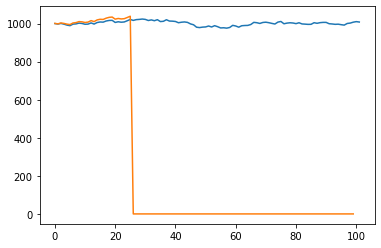

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from DataHandler import DataHandler
from TradingEnvDiscrete import TradingEnvironment
from TradingSimulatorDiscrete import TradingSimulator
# dynamics params
X_0 = 100000
q = 5000
F_0 = 1000 # init price
rho = 2.2231
lambda_ = 1/(2*q)
T = 1
N = 100
timestamps = list(range(0, N+1))#[n*T/N for n in range(0,N+1)]

def get_random_walk(scale_param = 5):
    P = F_0
    F = [P]
    for i in range(N+1):
        P += np.random.normal(0, 1)*scale_param
        F.append(P)
    return F
F = get_random_walk()
plt.plot(F)
data = pd.Series(F)

env = TradingEnvironment(TradingSimulator, data, len(data))
state = env.reset()
a = 0
rewards = 0
for i in range(len(data)):
    #print('step', env.simulator.step, '|| inventory:', env.simulator.inventory, '|| price', env.simulator.prices[i])
    state, reward, info, done = env.step(np.random.choice(10000))
    #print(np.clip((env.simulator.strategy_costs[env.simulator.step-1] - env.simulator.strategy_costs[env.simulator.step])/env.simulator.strategy_costs[env.simulator.step-1], -1, 1))
plt.plot(env.simulator.prices[:-1])

In [2]:
env2 = TradingEnvironment(TradingSimulator, data, len(data))

state = env2.reset()
a = 0
for i in range(len(data)):
    if i == 0 or i == len(data)-2:
        a = X_0/(rho*T + 2)
        state, reward, info, done = env2.step(a)
    else:
        a = rho*X_0/(rho*T+2)/(len(data)-3)
        state, reward, info, done = env2.step(a)
print('Average cost:', np.mean(env2.simulator.rewards))

Average cost: -9.70942953662309e-05


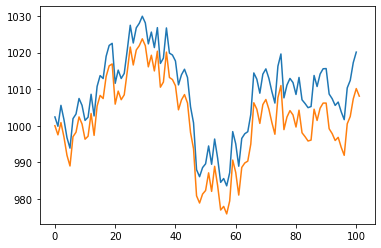

In [3]:
plt.plot(env2.simulator.prices)
plt.plot(data)

In [4]:
#for i in range(1, len(data)-2):
#    print(np.sum([env2.simulator.actions[i]*env.simulator.kappa*np.exp(-env2.simulator.rho*1/env.simulator.N*(env2.simulator.step - j)) for j in range(i)]))

In [5]:
#for i in range(len(data)-1):
#    print(np.sum([env2.simulator.actions[i]*env2.simulator.kappa*np.exp(-env2.simulator.rho*1/env2.simulator.N*(j - i)) for j in range(i)]))

In [6]:
print('Actions history', np.round(env2.simulator.actions, 4))
print('Sum', np.sum(env2.simulator.actions))
print('Env remain:', env2.simulator.remaining)
print('Rewards', np.round(env2.simulator.rewards, 4)[-4:])

print('=======')

print('Average cost:', np.mean(env2.simulator.rewards))
print('Total cost:', np.sum(env2.simulator.rewards))

Actions history [23679.2877   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316   531.7316   531.7316
   531.7316   531.7316   531.7316   531.7316  

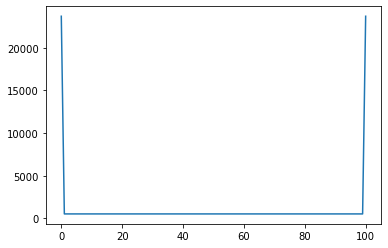

In [7]:
plt.plot(env2.simulator.actions)

In [8]:
#https://github.com/BY571/SAC_discrete

import gym
import numpy as np
from collections import deque
import torch
from buffer import ReplayBuffer
import glob
from utils import save, collect_random
import random
from agent import SAC


np.random.seed(1)
random.seed(1)
torch.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

steps = 0
average10 = deque(maxlen=10)
total_steps = 0
    

agent = SAC(state_size=4, action_size=101, device=device)

buffer = ReplayBuffer(buffer_size=10000, batch_size=64, device=device)

collect_random(env=env, dataset=buffer, num_samples=10000)

In [9]:
episodes = 11
for episode in range(episodes):
  state = env.reset()
  episode_steps = 0
  rewards = 0
  for s in range(len(data)):
      action = agent.get_action(state)
      steps += 1
      next_state, reward, info, done  = env.step(np.floor(action/100*env.simulator.remaining))
      buffer.add(state, action, reward, next_state, done)
      policy_loss, alpha_loss, bellmann_error1, bellmann_error2, current_alpha = agent.learn(steps, buffer.sample(), gamma=1)
      state = next_state
      rewards += reward
      episode_steps += 1
      if done:
            pass

  if episode % 1 == 0: # print average shortfall over last 100 episodes
        print('Episode:', episode, 'Average episode reward', np.mean(env.simulator.rewards), 'Total reward', np.sum(env.simulator.rewards))

Episode: 0 Average episode reward -9.71380719253026e-05 Total reward -0.009908083336380866
Episode: 1 Average episode reward -9.691288399124333e-05 Total reward -0.00988511416710682
Episode: 2 Average episode reward -9.70521921988663e-05 Total reward -0.009899323604284362
Episode: 3 Average episode reward -9.70521921988663e-05 Total reward -0.009899323604284362
Episode: 4 Average episode reward -9.703469224997596e-05 Total reward -0.009897538609497549
Episode: 5 Average episode reward -9.70521921988663e-05 Total reward -0.009899323604284362
Episode: 6 Average episode reward -9.70521921988663e-05 Total reward -0.009899323604284362
Episode: 7 Average episode reward -9.70521921988663e-05 Total reward -0.009899323604284362
Episode: 8 Average episode reward -9.700805367192041e-05 Total reward -0.009894821474535883
Episode: 9 Average episode reward -9.70461263767081e-05 Total reward -0.009898704890424225
Episode: 10 Average episode reward -9.684986672225872e-05 Total reward -0.00987868640567

In [10]:
#i = 100
#[np.exp(-env.simulator.rho*1/env.simulator.N*(i - j)) for j in range(i)]

In [11]:
#for i in range(1, len(data)-2):
#    print(np.sum([env.simulator.actions[i]*env.simulator.kappa*np.exp(-env.simulator.rho*1/env.simulator.N*(env.simulator.step - j)) for j in range(i)]))

In [13]:
print('Actions history', np.round(env.simulator.actions, 4))
print('Sum', np.sum(env.simulator.actions))
print('Env remain:', env.simulator.remaining)
print('Rewards', np.round(env.simulator.rewards, 4)[-4:])

print('=======')

print('Average reward:', np.mean(env2.simulator.rewards))
print('Total reward:', np.sum(env2.simulator.rewards))
print('Total cost (analytical):', np.sum(env2.simulator.execution_prices * env2.simulator.actions))
#print('Total cost:', np.sum(env2.simulator.strategy_costs))
print('=======')
print('Average rewards (RL):', np.mean(env.simulator.rewards))
print('Total reward (RL):', np.sum(env.simulator.rewards))
print('Total cost (RL):', np.sum(env.simulator.execution_prices * env.simulator.actions))
#print('Total cost (RL):', np.sum(env.simulator.strategy_costs))
print('=======')
print('cost ratio:',  np.sum(env.simulator.execution_prices * env.simulator.actions)/np.sum(env2.simulator.execution_prices * env2.simulator.actions))

Actions history [ 1000.   990.   980.   970.   960.   951.   941.   932.   922.     0.
     0.     0.   913.   904.   895.   886.     0.   877.     0.   868.
   860.   851.   843.   834.   826.   817.   809.   801.     0.   793.
   785.   777.   770.   762.   754.     0.   747.   739.   732.   725.
   717.     0.   710.   703.   696.     0.   689.     0.     0.   682.
     0.   675.     0.     0.   669.   662.     0.   655.     0.     0.
     0.   649.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.   642.     0.     0.     0.     0.
     0.     0.     0.     0.   636.     0.     0.     0.     0.     0.
   630.     0.     0.     0.   623.   617.     0.     0.   611.     0.
 60520.]
Sum 100000.0
Env remain: 0.0
Rewards [-0.0001  0.     -0.0063  0.    ]
Average reward: -0.00010043108266946355
Total reward: -0.010243970432285282
Total cost (analytical): 97776365.39211923
Average rewards (RL): -0.00010149555987455074
Total reward (RL): -0.0103525

In [24]:
print('Actions history', np.round(env.simulator.actions, 4))
print('Sum', np.sum(env.simulator.actions))
print('Env remain:', env.simulator.remaining)
print('Rewards', np.round(env.simulator.rewards, 4)[-4:])

print('=======')

print('Average reward:', np.mean(env2.simulator.rewards))
print('Total reward:', np.sum(env2.simulator.rewards))
print('Total cost (analytical):', np.sum(env2.simulator.execution_prices * env2.simulator.actions))
#print('Total cost:', np.sum(env2.simulator.strategy_costs))
print('=======')
print('Average rewards (RL):', np.mean(env.simulator.rewards))
print('Total reward (RL):', np.sum(env.simulator.rewards))
print('Total cost (RL):', np.sum(env.simulator.execution_prices * env.simulator.actions))
#print('Total cost (RL):', np.sum(env.simulator.strategy_costs))
print('=======')
print('cost ratio:',  np.sum(env.simulator.execution_prices * env.simulator.actions)/np.sum(env2.simulator.execution_prices * env2.simulator.actions))

Actions history [ 1000.   990.   980.   970.   960.   951.   941.   932.   922.   913.
   904.   895.   886.   877.   868.   860.     0.   851.   843.   834.
   826.   817.   809.   801.   793.   785.   777.   770.   762.   754.
   747.   739.   732.   725.   717.     0.   710.   703.   696.   689.
   682.     0.   675.     0.     0.     0.   669.     0.     0.     0.
     0.     0.     0.     0.   662.   655.     0.   649.     0.     0.
     0.   642.     0.   636.   630.     0.   623.   617.   611.   605.
   599.     0.   593.   587.     0.   581.     0.   575.     0.     0.
     0.     0.   569.     0.   564.     0.     0.     0.     0.   558.
   552.   547.   541.     0.   536.   531.     0.     0.   525.     0.
 52057.]
Sum 100000.0
Env remain: 0.0
Rewards [-0.0001  0.     -0.0051  0.    ]
Average reward: -9.70942953662309e-05
Total reward: -0.009903618127355553
Total cost (analytical): 101098498.38219102
Average rewards (RL): -9.684986672225872e-05
Total reward (RL): -0.009878686

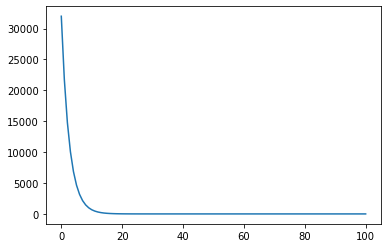

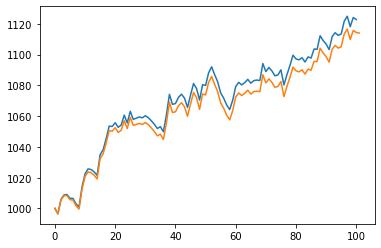

In [11]:
plt.plot(env.simulator.prices)
plt.plot(data)

In [ ]:
env.simulator.

In [22]:
SAC_actions_1 = env.simulator.actions.copy()

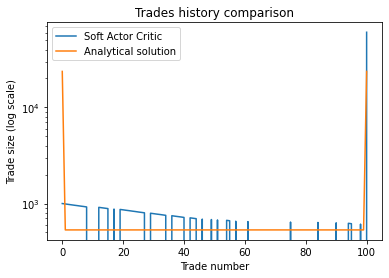

In [15]:
plt.plot(SAC_actions_1, label ='Soft Actor Critic')
#plt.plot(env.simulator.actions, label ='Soft Actor Critic (gamma = 0.9)')
plt.plot(env2.simulator.actions, label ='Analytical solution')
plt.ylabel('Trade size (log scale)')
plt.xlabel('Trade number')
plt.yscale('log')
plt.title('Trades history comparison')
plt.legend()

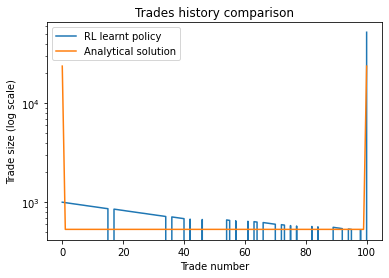

In [23]:
plt.plot(SAC_actions_1, label ='RL learnt policy')
#plt.plot(env.simulator.actions, label ='Soft Actor Critic (gamma = 0.9)')
plt.plot(env2.simulator.actions, label ='Analytical solution')
plt.ylabel('Trade size (log scale)')
plt.xlabel('Trade number')
plt.yscale('log')
plt.title('Trades history comparison')
plt.legend()

In [17]:
accum_costs2 = [np.sum((env2.simulator.execution_prices*env2.simulator.actions)[:t]) for t in range(len(data))]
accum_costs = [np.sum((env.simulator.execution_prices*env.simulator.actions)[:t]) for t in range(len(data))]

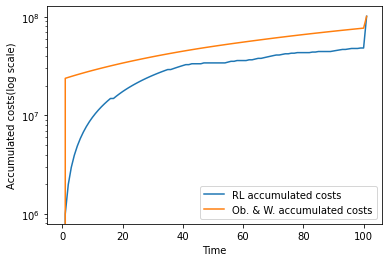

In [21]:
plt.plot(accum_costs, label = 'RL accumulated costs')
plt.plot(accum_costs2 , label='Ob. & W. accumulated costs')
plt.ylabel('Accumulated costs(log scale)')
plt.xlabel('Time')
plt.yscale('log')
plt.legend()

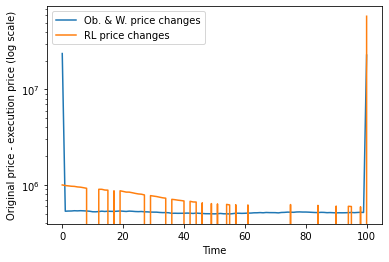

In [31]:
plt.plot(env2.simulator.execution_prices*env2.simulator.actions , label='Ob. & W. price changes')
plt.plot(env.simulator.execution_prices*env.simulator.actions, label = 'RL price changes')
plt.ylabel('Original price - execution price (log scale)')
plt.xlabel('Time')
plt.yscale('log')
plt.legend()

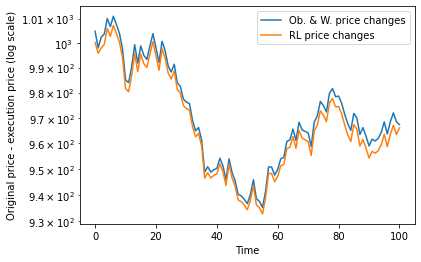

In [18]:
plt.plot(env2.simulator.execution_prices , label='Ob. & W. price changes')
plt.plot(env.simulator.execution_prices, label = 'RL price changes')
plt.ylabel('Original price - execution price (log scale)')
plt.xlabel('Time')
plt.yscale('log')
plt.legend()

In [28]:
np.sum((env2.simulator.execution_prices - env2.simulator.prices)**2)

11.494084413692802

In [27]:
np.sum((env.simulator.execution_prices - env.simulator.prices)**2)

94.49117978000203

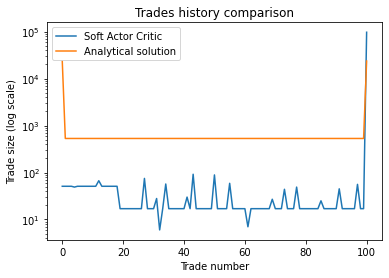

In [34]:
plt.plot(env.simulator.actions, label ='Soft Actor Critic')
#plt.plot(env.simulator.actions, label ='Soft Actor Critic (gamma = 0.9)')
plt.plot(env2.simulator.actions, label ='Analytical solution')
plt.ylabel('Trade size (log scale)')
plt.xlabel('Trade number')
plt.yscale('log')
plt.title('Trades history comparison')
plt.legend()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [16]:
BATCH_SIZE = 128
LR = 0.01
GAMMA = 1
EPISILO = 0.9
MEMORY_CAPACITY = 20000
Q_NETWORK_ITERATION = 100

NUM_ACTIONS = env.action_space.n
NUM_STATES = 4
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample.shape
class Net(nn.Module):
    """docstring for Net"""
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 50)
        self.fc1.weight.data.normal_(0,0.1)
        self.fc2 = nn.Linear(50,30)
        self.fc2.weight.data.normal_(0,0.1)
        self.out = nn.Linear(30,NUM_ACTIONS)
        self.out.weight.data.normal_(0,0.1)

    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        action_prob = self.out(x)
        return action_prob

class DQN():
    """docstring for DQN"""
    def __init__(self):
        super(DQN, self).__init__()
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter = 0
        self.memory_counter = 0
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        # why the NUM_STATE*2 +2
        # When we store the memory, we put the state, action, reward and next_state in the memory
        # here reward and action is a number, state is a ndarray
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()

    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0) # get a 1D array
        if np.random.randn() <= EPISILO:# greedy policy
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        else: # random policy
            action = np.random.randint(0,NUM_ACTIONS)
            action = action if ENV_A_SHAPE ==0 else action.reshape(ENV_A_SHAPE)
        return action


    def store_transition(self, state, action, reward, next_state):
        transition = np.hstack((state, [action, reward], next_state))
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1


    def learn(self):

        #update the parameters
        if self.learn_step_counter % Q_NETWORK_ITERATION ==0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter+=1

        #sample batch from memory
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1:NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:,-NUM_STATES:])

        #q_eval
        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        loss = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

dqn = DQN()
episodes = 250
print("Collecting Experience....")
for i in range(episodes):
    state = env.reset()
    ep_reward = 0
    while True:
        action = dqn.choose_action(state)
        next_state, reward, info, done = env.step(action)

        dqn.store_transition(state, action, reward, next_state)
        ep_reward += reward

        if dqn.memory_counter >= MEMORY_CAPACITY:
            dqn.learn()
            if done:
                print("episode: {} , the episode reward is {}".format(i, round(ep_reward, 3)))
        if done:
            break
        state = next_state

episode: 196 , the episode reward is -10.0
episode: 197 , the episode reward is -10.0
episode: 198 , the episode reward is -10.0
episode: 199 , the episode reward is -10.0
episode: 200 , the episode reward is -10.0
episode: 201 , the episode reward is -10.0
episode: 202 , the episode reward is -10.0
episode: 203 , the episode reward is -10.0
episode: 204 , the episode reward is -10.0
episode: 205 , the episode reward is -10.0
episode: 206 , the episode reward is -10.0
episode: 207 , the episode reward is -10.0
episode: 208 , the episode reward is -10.0
episode: 209 , the episode reward is -10.0
episode: 210 , the episode reward is -10.0
episode: 211 , the episode reward is -10.0
episode: 212 , the episode reward is -10.0
episode: 213 , the episode reward is -10.0
episode: 214 , the episode reward is -10.0
episode: 215 , the episode reward is -10.0
episode: 216 , the episode reward is -10.0
episode: 217 , the episode reward is -10.0
episode: 218 , the episode reward is -10.0
episode: 21

In [18]:
print('Actions history', np.round(env.simulator.actions, 2))
print('Sum', np.sum(env.simulator.actions))
print('Env remain:', env.simulator.remaining)
print('Rewards', np.round(env.simulator.rewards, 4)[-4:])

print('=======')

print('Average reward:', np.mean(env2.simulator.rewards))
print('Total reward:', np.sum(env2.simulator.rewards))
print('Total cost (analytical):', np.sum(env2.simulator.execution_prices * env2.simulator.actions))
#print('Total cost:', np.sum(env2.simulator.strategy_costs))
print('=======')
print('Average rewards (RL):', np.mean(env.simulator.rewards))
print('Total reward (RL):', np.sum(env.simulator.rewards))
print('Total cost (RL):', np.sum(env.simulator.execution_prices * env.simulator.actions))
#print('Total cost (RL):', np.sum(env.simulator.strategy_costs))
print('=======')
print('cost ratio:',  np.sum(env.simulator.execution_prices * env.simulator.actions)/np.sum(env2.simulator.execution_prices * env2.simulator.actions))

Actions history [5.1000e+01 5.1000e+01 5.1000e+01 5.1000e+01 4.9000e+01 5.1000e+01
 5.1000e+01 5.1000e+01 5.1000e+01 5.1000e+01 5.1000e+01 5.1000e+01
 6.7000e+01 5.1000e+01 5.1000e+01 5.1000e+01 5.1000e+01 5.1000e+01
 5.1000e+01 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01
 1.7000e+01 1.7000e+01 1.7000e+01 7.5000e+01 1.7000e+01 1.7000e+01
 1.7000e+01 2.8000e+01 6.0000e+00 1.7000e+01 5.7000e+01 1.7000e+01
 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01 3.0000e+01
 1.7000e+01 9.2000e+01 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01
 1.7000e+01 1.7000e+01 8.9000e+01 1.7000e+01 1.7000e+01 1.7000e+01
 1.7000e+01 5.9000e+01 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01
 1.7000e+01 7.0000e+00 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01
 1.7000e+01 1.7000e+01 1.7000e+01 2.7000e+01 1.7000e+01 1.7000e+01
 1.7000e+01 4.4000e+01 1.7000e+01 1.7000e+01 1.7000e+01 4.9000e+01
 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01 1.7000e+01
 1.7000e+01 2.5000e+01 1.7000e+01 1.7000e+01 1